# Machine Learning on Traffic Hotspot
In the following program, we would guide you through use Tensorflow library to load and process traffic data. Then we would teach you how to create and train your Tensorflow model.

**Note: Hit the "Run" button to run the program block by block. We don't recommend you to use "Run All" in "Cell" because the first few blocks only need to be run once and they take some time to run.**

## Import Libraries
The following block is used in Python to import necessary libraries. You might encounter error while trying to import tensorflow. This is becuase Tensorflow is not a default library that comes with the Python package you installed. Go to this link https://www.tensorflow.org/install/pip#system-install and follow the instructions on installing Tensorflow. If you encounter problems while trying to install Tensorflow you can add `--user` after `pip install`. This is because you did not create a virtual environment for your python packages. You can follow Step 2 on the website to create a virtual environment (recommended) or you can just install the package in your HOME environment.

* `pandas` is used to process our data.

* `numpy` is a great tool for mathematical processing and array creations.

* `sklearn` is used to split the data into Training, Testing, and Validation set.

In [63]:
# Load the TensorBoard notebook extension.
from datetime import datetime
from packaging import version

# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Load and Clean up the Dataset
To process the data, save the data.txt and label.txt file you downloaded from the Google Drive to the same directory where this Notebook is at.
* `with open(label_src, 'r')` reads the data into label

    * Note that we call `np` directly becuase we import `numpy as np`
    
* `.from_tensor_slices()` .would bind numpy array data and label together to creat a tensorflow data set

In [8]:
data_src = "sample data\\data.txt"
label_src = "sample data\\label.txt"

with open(label_src, 'r') as f:
    label = np.array(f.read().split())
label = label.astype("float")

data = []
with open(data_src, 'r') as f:
    for line in f:
        data.append(line.split())
data = np.array(data)
data = data.astype("float")

dataset = tf.data.Dataset.from_tensor_slices((data, label))


We seperated the block above from the block below becuase we don't want you to read the data twice. Reading a large file as you might have experienced a few minutes ago take up quite some RAM and CPU.

**To-do:** 
1. Print out the **shape** of our datasets. 

In [9]:
print("shape of features is {}".format(np.shape(data)))
print("shape of labels is {}".format(np.shape(label)))
### Insert your code below ###


shape of features is (7894, 200)
shape of labels is (7894,)


By now, you acquire the shape of our dataset, the first demension give us the number of data points, and the second dimension give us teh size of each data point.
    For example, feature size of (4000, 800) would represent a dataset of 4000 data, and each data is a 800 entry list. When designing model later, we must make sure the the input layer have the same input size as our data size.Later,we need to shuffle the data and separate it in to batches before we can use it. 


**To-do:**
1. Shuffle the data set

In [54]:
BATCH_SIZE = 1000
SHUFFLE_BUFFER_SIZE = 100000 
#dataset is fully shuffled only when shuffle_buffer_size larger the data size.

# Shuffle the dataset
dataset_shuffled = dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)


Now the dataset would be divided in to different batches, we can check the number of batch by using following code. And we expect # batch = # data / batch_size

In [55]:
print("Number of batches in dataset is {}".format(tf.data.experimental.cardinality(dataset_shuffled)))

Number of batches in dataset is 8


## *Stop*
*Before you proceed, make sure you finish reading "Machine Learning Introduction" in Step 3 of the lab. You should complete the Tensorflow playground exercise and take a screenshot of your results.*   

## Split Data for Machine Learning
In machine learning, we often want to split our data into Training Set, Validation Set, and Test Set.
* **Training Set**:
Training Set is used to train our machine learning model while the Validation and Test Set aren't. 
* **Validation Set**:
Having a Validation Set prevents overfitting of our machine learning model. Overfitting is when our model is tuned perfectly for a specific set of data, but is fitted poorly for other set of data. Take traffic emission data for example. If the data predicts $CO_2$ emission data within 10 mse (mean squared error) from Training Set, but predicts emission data over 50 mse from Validation data. Then we could see that the model is overfitted.
* **Test Set**:
Test set is used to evaluate the final model.

A typical workflow will be: 
1. Train your model using *Training Set*.
2. Validate your model using *Validation Set*.
3. Adjust your model using results from *Validation Set*.
4. Pick the model that produces best results from using *Validation Set*.
5. Confirm your model with *Test Set*.

**To-Do:**
1. Tweak the `test_size` values for spilitting `train_dataset`, `test_dataset`, and `val_dataset`.

2. In given code 80% of all data would be used for train, 10% data would be used for validation and 10% of data would be used for test, you can change this ratio by change parameter in calculating train_size, val_size and test_size

3. You will come back and change some codes after you finish your first training. Instructions will be provided in the "Train the Model" section.

In [56]:
DATASET_SIZE = tf.data.experimental.cardinality(dataset_shuffled).numpy()
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train_dataset = dataset_shuffled.take(train_size)
test_dataset = dataset_shuffled.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

print("total dataset size {}".format(DATASET_SIZE))
print("train dataset size {}".format(tf.data.experimental.cardinality(train_dataset)))
print("test dataset size {}".format(tf.data.experimental.cardinality(test_dataset)))
print("validation dataset size {}".format(tf.data.experimental.cardinality(val_dataset)))

total dataset size 8
train dataset size 6
test dataset size 0
validation dataset size 2


## Create Model and Training Function

The below code block defines function for creating and trining a sequential Tensorflow model. You can also train the model without function definition. Just replace the function call in the next block after this one with: 

`model = tf.keras.models.Sequential()`
<br>&emsp;&emsp;&emsp;&emsp;.
<br>&emsp;&emsp;&emsp;&emsp;.
<br>&emsp;&emsp;&emsp;&emsp;.
<br>`model.save('my_model')`

Also replace the input variables with the correct names. Note that the first function returns a variable. 

However, these function definitions make the code less messy. There is another way to write Tensorflow, which is called Functional API. It is more advanced. If you want to learn more, please go to https://www.tensorflow.org/guide/keras/functional. 

### Function Definition
1. Create model 
    * `model.add()`: add layer to model
    
    * In `tf.keras.layers.Dense()`
    
        * `units`: number of nodes in that layer
        
        * `activation`: activation function used in that layer
        
        * `kernel_regularizer`: regularization function used in that layer
        
        * `name`: is just for us to keep track and debug
        
    * In `model.compile()`
    
        * `optimizer=tf.keras.optimizers.Adam(lr=learning_rate)`: Used to improve performance of the training
        
        * `Adam`: stochastic gradient descent method
        
        * `loss`: update the model according to specified loss function 
        
        * `metrics`: evaluate the model according specified metrics
        

    
**To-do:**
See next section.

In [57]:
def modelCreate(learning_rate):
    
    # Sequential is used in most simple keras models
    model = tf.keras.models.Sequential([
        
        # First hidden layer with 80 nodes
        tf.keras.layers.Dense(units=80, 
                              activation='relu',
                              name='Hidden1'),
        
        # Dropout layer
        tf.keras.layers.Dropout(0.5, name='Dropout1'),
        
        # Second hidden layer
        tf.keras.layers.Dense(units=20, 
                              activation='relu', #change to relu 
                              name='Hidden2'),

        
        # Output layer
        tf.keras.layers.Dense(units=1,  
                              activation='sigmoid', #change to sigmoid
                              name='Output')
      
        #Create your own model
        
        
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

## Train the Model
As we mentioned in the lab document, Hyperparameters affect the performance of your model. In the following block, you would be training your model. We also want you to experience training both a small dataset and a large dataset. 

**To-do:**
    
    1. Adjust the Hyperparameters. Remember, a large learning rate might cause the model to never converge, but a very small learning rate would cause the model to converge very slow. If your accuracy is increasing but your program finishes before the acuracy reaches a big number, increase your epochs. Lastly, a large batch size might give you a better convergence, but it might also lead to poor generalization and slow training speed. Try batch sizes of 1000, 10000, 200000. We recommend you use a batch sizes of around 150000 for getting your final model, but do experiment with the batch sizes listed above. <u>Q: Do you notice any difference between using batch sizes of 1000, 10000, 200000?</u>
    
    2. In the function definitions:
        * Press the stop button (**interrupt the kernal**) next to Run before you change the values in the functions above. 
        * Add or reduce Hidden layers if your model turns our poorly. 
        * Adjust the amount of nodes in each Hidden layer. 
        * Try out different activation functions. 
        * Try different regularizers. 
        * You should aim to get an **mse < 100**.
        
    3. The program will run for a longer time with large dataset input. Once you get a result with nice mse, you don't have to run `%tensorboard --logdir logs`. Please click on "File -> Print Preview" and a separate page should open. Press Cmd/Ctrl + p to print. Select "Save as PDF". We will look at your training for the large dataset based on the logs printed out during each epoch.
    

*Note: Ignore the warnings at the beginning and at the end.*

<u>Type your answers to Q:</u>

In [65]:
from tensorflow.keras.callbacks import EarlyStopping
#useing EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min')

LEARNING_RATE = 0.01 #change to 0.01 for better accuracy

model = modelCreate(LEARNING_RATE)
history = model.fit(train_dataset, batch_size=BATCH_SIZE, epochs=100, validation_data=val_dataset,  callbacks=[early_stopping])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7097 - loss: 11.6985 - val_accuracy: 0.8115 - val_loss: 1.1411
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6754 - loss: 2.9204 - val_accuracy: 0.8184 - val_loss: 0.7058
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7945 - loss: 1.3447 - val_accuracy: 0.8395 - val_loss: 0.5527
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7959 - loss: 0.7826 - val_accuracy: 0.7540 - val_loss: 0.5368
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7980 - loss: 0.6058 - val_accuracy: 0.8258 - val_loss: 0.4947
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8269 - loss: 0.5124 - val_accuracy: 0.8485 - val_loss: 0.4588
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8359 - loss: 0.4967 - val_accuracy: 0.8458 - val_loss: 0.4274
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8417 - loss: 0.4474 - val_accuracy: 0.8205 - val_loss: 0.45

You may find the accuracy of data is hard to increase, this is because the data in this case is highly inbalance, which, in this case, means that the data cooresponding to no traffic hotspot is far more than the data cooresponding to existing traffic hotspot. You may explore methods of increasing the accuracy by using techniques like increasing sample size, down sampling, up sampling, etc.

## Model Summary

In [62]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden1 (Dense)                 │ (None, 80)             │        16,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden2 (Dense)                 │ (None, 20)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,165 (207.68 KB)

 Trainable params: 17,721 (69.22 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,444 (138.46 KB)

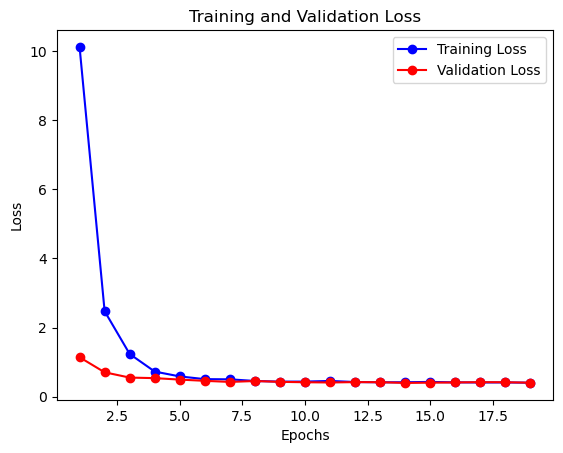

In [66]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Well Done!
**Congradulation on finishing the lab. Submit this .ipnyb Notebook file, the PDF, and loss graph screenshots to the link specified in the Google Doc.**  